In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
base_path = "drive/MyDrive/English/Img/GoodImg/Bmp"

if os.path.exists(base_path):
    print("Path exists!")
else:
    print("Invalid path. Please check.")

Path exists!


In [4]:
def preprocess_image(image, img_size=(28, 28)):
    """
    Preprocesses a single image: resize, normalize, and optionally denoise.
    """
    # Apply GaussianBlur to reduce noise
    image = cv2.GaussianBlur(image, (3, 3), 0)

    # Thresholding for binarization (if needed)
    _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Resize to the target size
    image = cv2.resize(image, img_size)

    # Normalize pixel values to [0, 1]
    image = image / 255.0

    return image

In [5]:
def load_dataset(base_path, img_size=(28, 28)):
    """
    Loads a dataset of images from a directory structure.

    Args:
        base_path (str): Base path to dataset.
        img_size (tuple): Target size for resizing images.

    Returns:
        tuple: (data, labels) where data is an array of processed images
               and labels are their corresponding class labels.
    """
    data = []
    labels = []

    for folder in sorted(os.listdir(base_path)):  # Sorted to keep label consistency
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            # Extract numeric label from folder name
            label = int(folder[-1]) - 1  # Adjust as per label naming convention
            for image_file in os.listdir(folder_path):
                if image_file.endswith(('.png', '.jpg', '.bmp')):
                    image_path = os.path.join(folder_path, image_file)
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    if image is not None:
                        image = preprocess_image(image, img_size)  # Apply preprocessing
                        data.append(image.flatten())
                        labels.append(label)

    # Convert lists to numpy arrays
    data = np.array(data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)

    print(f"Dataset loaded: {len(data)} samples.")
    print("Data shape:", data.shape)
    print("Labels shape:", labels.shape)

    return data, labels

In [6]:
img_size = (28, 28)

data, labels = load_dataset(base_path, img_size)

Dataset loaded: 351 samples.
Data shape: (351, 784)
Labels shape: (351,)


In [7]:
def show_random_images(data, labels, img_size=(32, 32), num_images=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        idx = np.random.randint(0, len(data))  # Random index
        img = data[idx].reshape(img_size)  # Reshape flat image
        label = labels[idx]

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

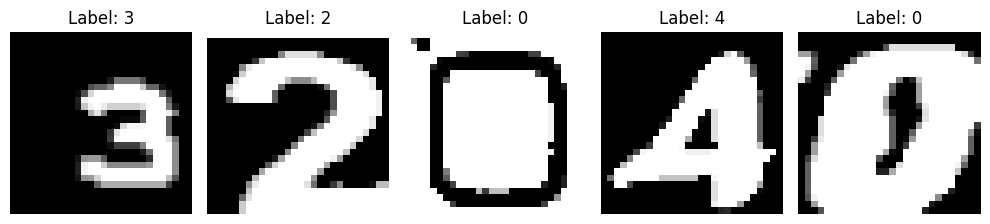

In [8]:
show_random_images(data, labels, img_size, num_images=5)

In [9]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}, Test Data Shape: {X_test.shape}")

Training Data Shape: (280, 784), Test Data Shape: (71, 784)


In [10]:
print(f"Test Data Shape: {y_train.shape}, Test Labels Data Shape: {y_test.shape}")

Test Data Shape: (280,), Test Labels Data Shape: (71,)


In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Logistic Regression with increased iterations and scaling
logistic_model = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial', class_weight='balanced')
logistic_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=2000,
                   multi_class='multinomial')

In [14]:
# Evaluate the model
y_pred_logistic = logistic_model.predict(X_test)
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_logistic, zero_division=1))
print(f"Accuracy: {accuracy_score(y_test, y_pred_logistic):.2f}")

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.48      0.54      0.51        24
           1       0.42      0.44      0.43        18
           2       0.09      0.08      0.09        12
           3       0.25      0.12      0.17         8
           4       0.40      0.44      0.42         9

    accuracy                           0.38        71
   macro avg       0.33      0.33      0.32        71
weighted avg       0.36      0.38      0.37        71

Accuracy: 0.38


In [16]:
# K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance')  # Distance-based weighting
knn_model.fit(X_train, y_train)

# Evaluate KNN
y_pred_knn = knn_model.predict(X_test)
print("K-Nearest Neighbors Results:")
print(classification_report(y_test, y_pred_knn, zero_division=1))
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.2f}")


K-Nearest Neighbors Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       0.77      0.94      0.85        18
           2       0.83      0.83      0.83        12
           3       0.80      0.50      0.62         8
           4       1.00      0.89      0.94         9

    accuracy                           0.89        71
   macro avg       0.88      0.83      0.85        71
weighted avg       0.89      0.89      0.88        71

Accuracy: 0.89


Logistic Regression Predictions:


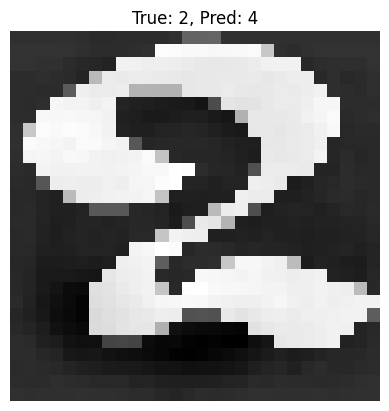

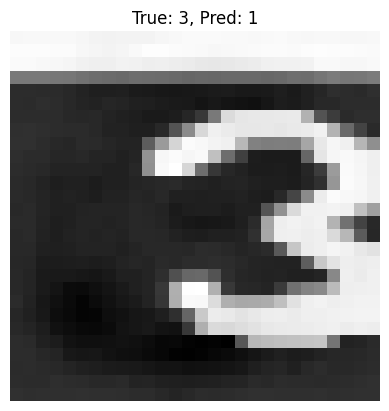

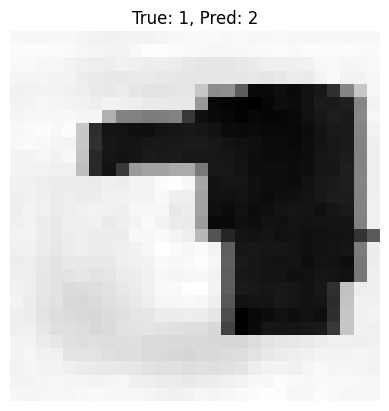

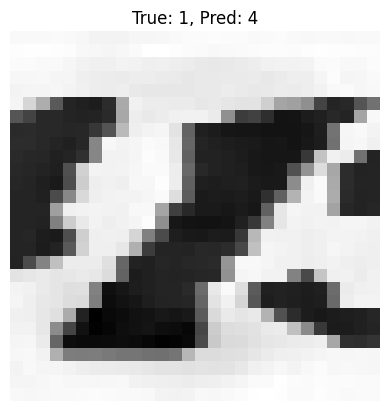

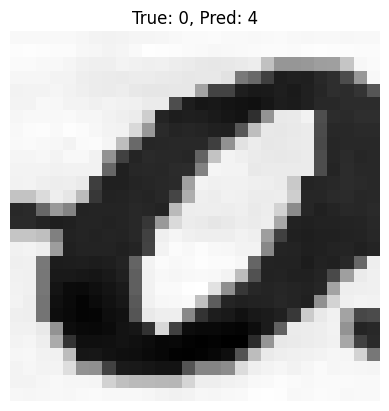

KNN Predictions:


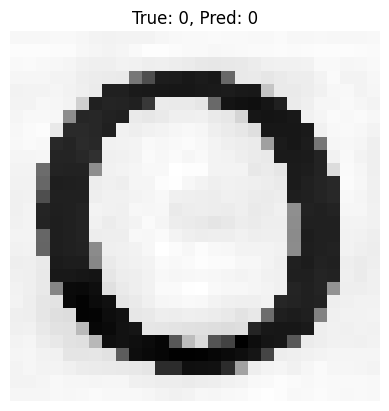

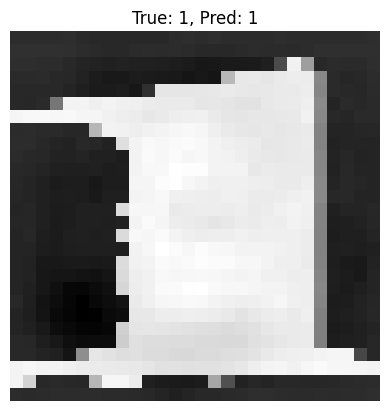

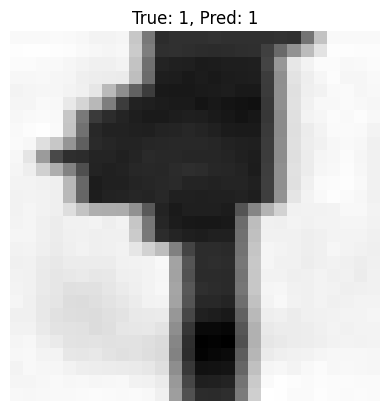

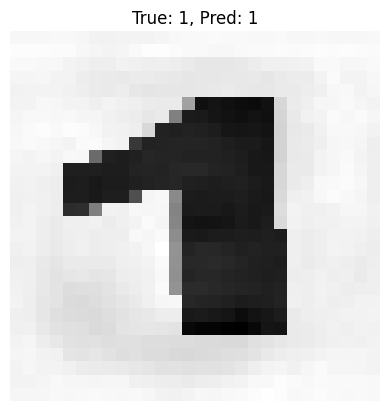

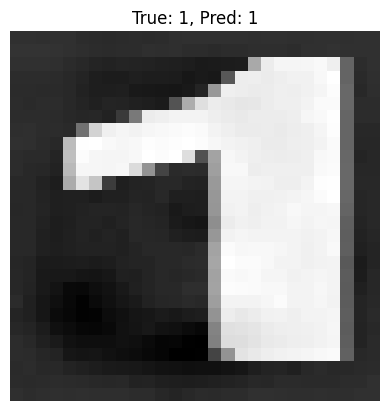

In [17]:
def visualize_predictions(model, X, y_true, img_size=(28, 28), num_samples=5):
    indices = np.random.choice(len(X), num_samples, replace=False)
    for idx in indices:
        img = X[idx].reshape(img_size)
        true_label = y_true[idx]
        pred_label = model.predict([X[idx]])[0]
        plt.imshow(img, cmap='gray')
        plt.title(f"True: {true_label}, Pred: {pred_label}")
        plt.axis('off')
        plt.show()

# Visualize for Logistic Regression
print("Logistic Regression Predictions:")
visualize_predictions(logistic_model, X_test, y_test, img_size)

# Visualize for KNN
print("KNN Predictions:")
visualize_predictions(knn_model, X_test, y_test, img_size)

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels for multi-class ROC
classes = len(np.unique(labels))  # Number of classes
y_train_bin = label_binarize(y_train, classes=np.arange(classes))
y_test_bin = label_binarize(y_test, classes=np.arange(classes))

In [21]:
y_score_logistic = logistic_model.predict_proba(X_test)
y_score_knn = knn_model.predict_proba(X_test)

In [23]:
# Compute ROC curve and AUC for Logistic Regression
fpr_logistic, tpr_logistic, roc_auc_logistic = {}, {}, {}
for i in range(classes):
    fpr_logistic[i], tpr_logistic[i], _ = roc_curve(y_test_bin[:, i], y_score_logistic[:, i])
    roc_auc_logistic[i] = auc(fpr_logistic[i], tpr_logistic[i])

# Compute ROC curve and AUC for KNN
fpr_knn, tpr_knn, roc_auc_knn = {}, {}, {}
for i in range(classes):
    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_test_bin[:, i], y_score_knn[:, i])
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])

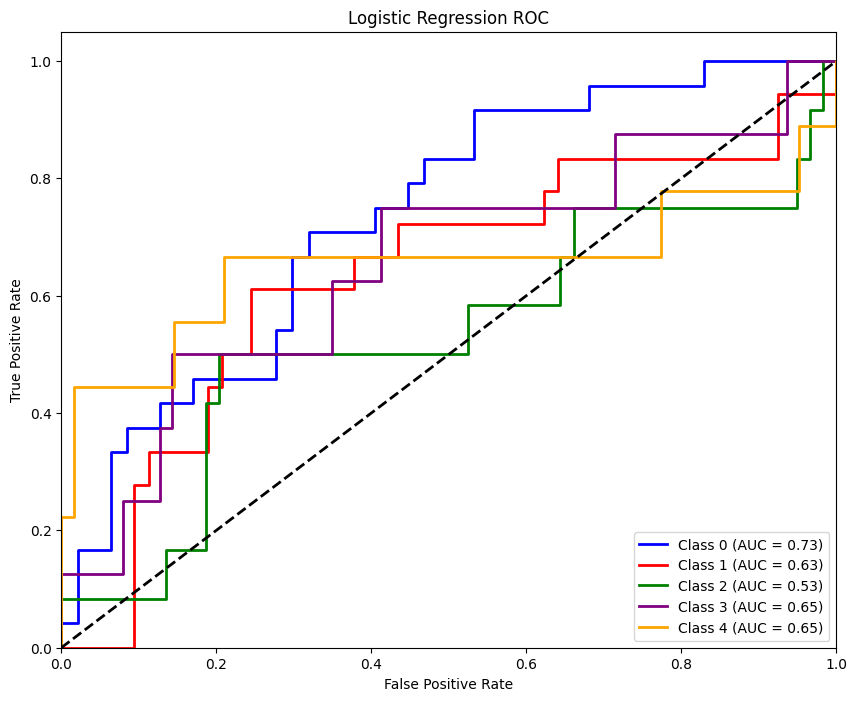

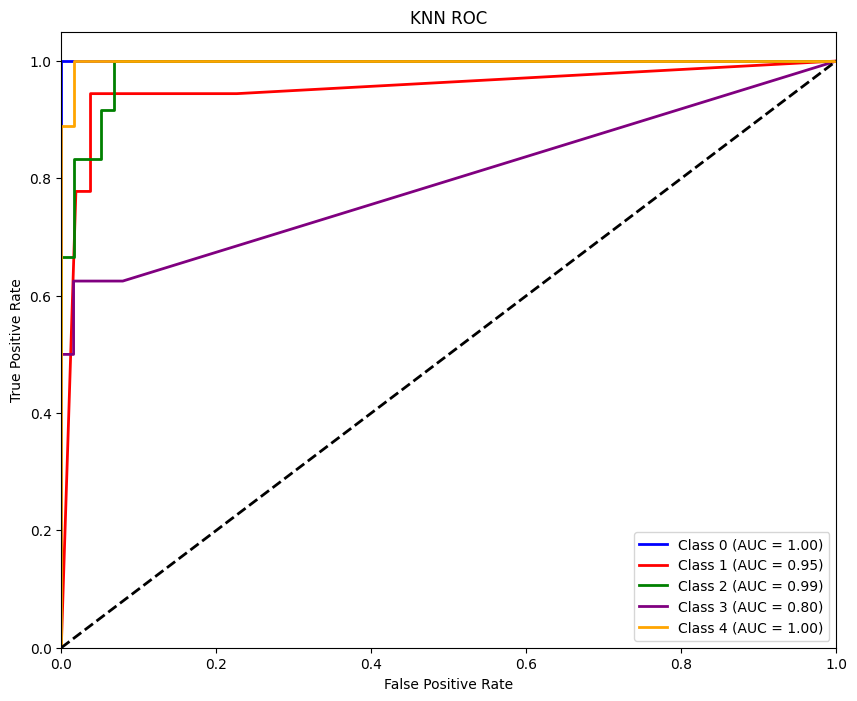

In [24]:
# Plotting function
def plot_roc(fpr, tpr, roc_auc, classes, title):
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'purple', 'orange'])
    for i, color in zip(range(classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC for Logistic Regression
plot_roc(fpr_logistic, tpr_logistic, roc_auc_logistic, classes, "Logistic Regression ROC")

# Plot ROC for KNN
plot_roc(fpr_knn, tpr_knn, roc_auc_knn, classes, "KNN ROC")

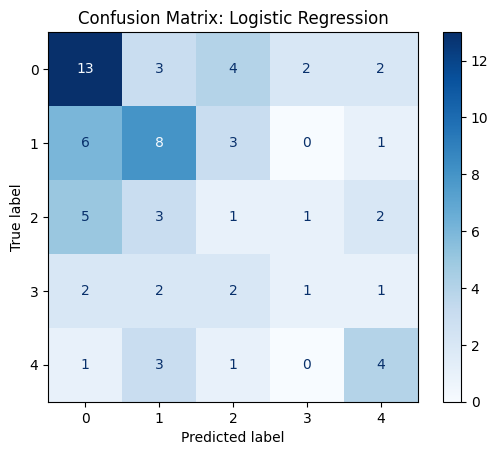

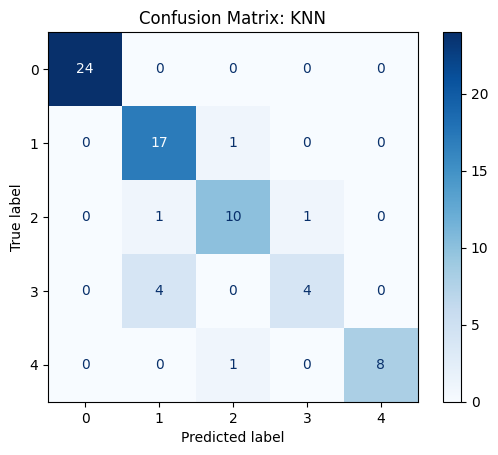

Log Loss (Logistic Regression): 2.9084
Log Loss (KNN): 2.1822


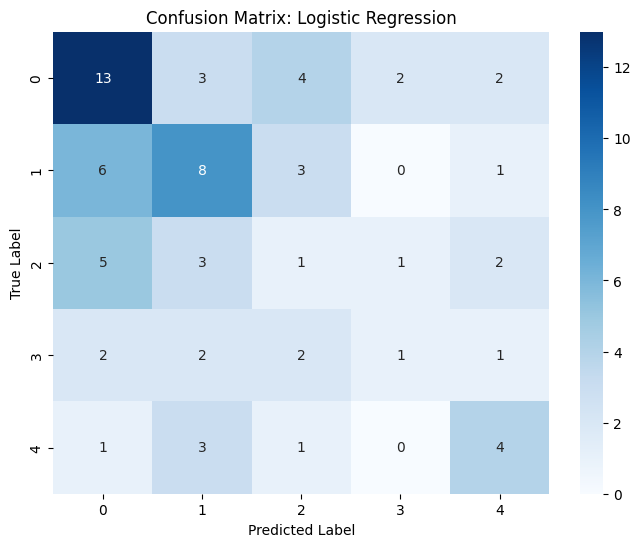

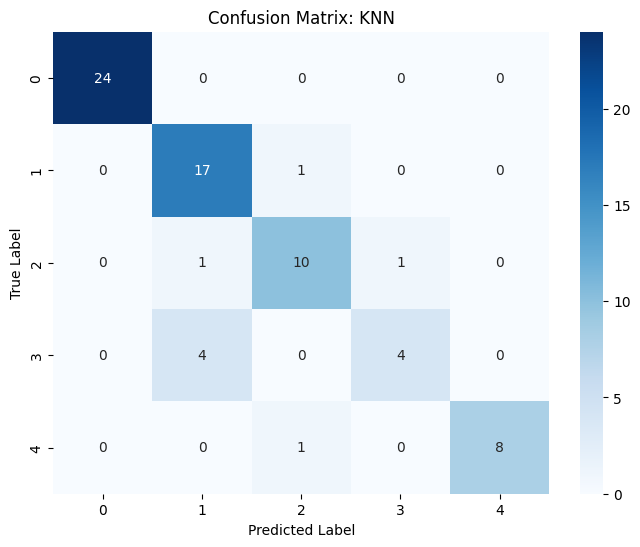

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix for Logistic Regression
cm_logistic = confusion_matrix(y_test, y_pred_logistic)
disp_logistic = ConfusionMatrixDisplay(confusion_matrix=cm_logistic)
disp_logistic.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix: Logistic Regression")
plt.show()

# Confusion Matrix for KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn)
disp_knn.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix: KNN")
plt.show()

# Loss Calculation
loss_logistic = log_loss(y_test, logistic_model.predict_proba(X_test))
print(f"Log Loss (Logistic Regression): {loss_logistic:.4f}")

loss_knn = log_loss(y_test, knn_model.predict_proba(X_test))
print(f"Log Loss (KNN): {loss_knn:.4f}")

# Confusion Matrix with Heatmaps
plt.figure(figsize=(8, 6))
sns.heatmap(cm_logistic, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.title("Confusion Matrix: Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.title("Confusion Matrix: KNN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()